In [16]:
import os



# Diffusion Model

In [17]:
from diffusers import StableDiffusionPipeline
from PIL import Image
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
model_id = "runwayml/stable-diffusion-v1-5"

# Check if CUDA is available
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float32, safety_checker=None
)

if device == "mps":
    pipe = pipe.to("cpu")
    pipe.enable_attention_slicing()
    # 将 VAE 和 UNET 移到 MPS 设备
    pipe.vae = pipe.vae.to(device)
    pipe.unet = pipe.unet.to(device)
    pipe.text_encoder = pipe.text_encoder.to(device)
else:
    pipe = pipe.to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

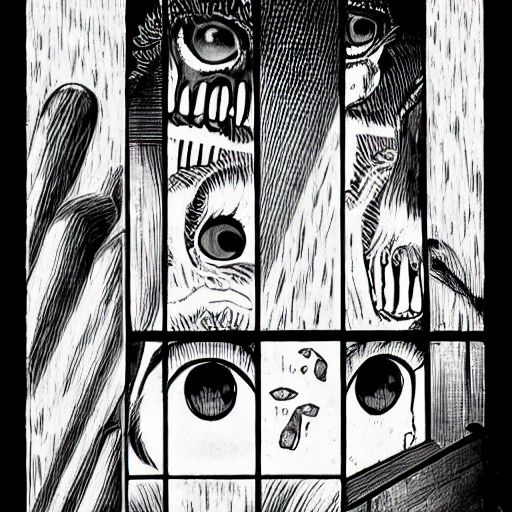

In [30]:
# prompt = "portrait of an ugly screaming classical greek hero with bulging eyes, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha"
# prompt = 'epic full - body - shot still of kim kardashian unconscious in a transparent alien liquid, wet flowing hair, gooey skin, illustration, unreal engine 5, 8 k, made by h. r. giger.'
# prompt = 'a closeup portrait of a young man licking a tab of LSD acid on his tongue and dreaming psychedelic hallucinations, by kawase hasui, moebius, Edward Hopper and James Gilleard, Zdzislaw Beksinski, Steven Outram colorful flat surreal design, hd, 8k, artstation'
# prompt = 'photographic portrait by Annie Leibovitz of XQC in a hot tub, closeup, foggy, sepia, moody, dream-like, sigma 85mm f/1.4, 15mm, 35mm, 4k, high resolution, 4k, 8k, hd, full color'
# prompt = 'elon musk boudoir photoshoot for calvin klein'
# prompt = 'retro cyber women crying in hell'
# prompt = 'young alluring elven woman with pretty legs, soft belly, wide hips, hand on hip, elegant feet, pretty aphrodite face, dressed as a greek goddess in a sultry pose, vignette, warm bi color palette, subtle chromatic aberration, soft glow, extreme rim light, subsurface scattering, ambient occlusion, ambient lighting, heavy oil painted by leonardo da vinci, van gogh'
# prompt = 'psycho anime woman with rainbow hair, artsy, cute,, soft eyes and narrow chin, dainty figure, long hair straight down, torn overalls, skimpy shorts, combat boots, fish net stockings, basic white background, side boob, in the rain, wet shirt, symmetrical, single person, style of by Jordan Grimmer and greg rutkowski, crisp lines and color,'
# prompt = "a nude lady showing in the tub"
# prompt = 'digging my own grave 🪦, science fiction, Edward Hopper and James Gilleard, Zdzislaw Beksinski, highly detailed'
# prompt = 'the pickled puckle gun'
# prompt = 'dog eating croissants in paris cartoon'
# prompt = 'a grey alien being arrested by russian special forces'
# prompt = 'cs:go player s1mple holding and awp and saying that the awp is the easiest weapon in the game'

prompt = 'horror manga panel of absolute horror abomination by junji ito and kentaro miura that is peaking through the window, black and white, highly detailed on small details,'
with torch.autocast(device):
    image = pipe(prompt).images[0]

image

# SAM Model

In [20]:
import requests

def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

# URL for the ViT-H SAM model checkpoint
sam_checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
sam_checkpoint = "sam_vit_h_4b8939.pth"

download_file(sam_checkpoint_url, sam_checkpoint)
print("SAM model checkpoint downloaded.")


SAM model checkpoint downloaded.


In [21]:
model_type = "vit_h"  # Options: 'vit_h', 'vit_l', 'vit_b'
sam_checkpoint = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [32]:
# Assuming 'image' is the PIL Image from Stable Diffusion
image = np.array(image)


In [33]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [34]:
masks = mask_generator.generate(image)
print(f"Generated {len(masks)} masks.")


Generated 41 masks.


In [35]:
def show_anns_on_image(image, anns, alpha=0.7):
    """
    Overlays segmentation masks on the original image with different colors.

    Parameters:
    - image: The original image as a NumPy array.
    - anns: A list of annotations (masks) from SAM.
    - alpha: Transparency factor for the overlay masks (default is 0.5).

    """
    if len(anns) == 0:
        return

    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)

    # Create a copy of the original image to overlay masks
    overlay = image.copy()

    # Create an image for the colored masks
    mask_image = np.zeros_like(image, dtype=np.uint8)

    for ann in sorted_anns:
        segmentation = ann['segmentation']
        color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)

        # Apply the color to the mask_image where segmentation is True
        mask_image[segmentation] = color

    # Combine the original image with the mask image using the alpha parameter
    cv2.addWeighted(mask_image, alpha, overlay, 1 - alpha, 0, overlay)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


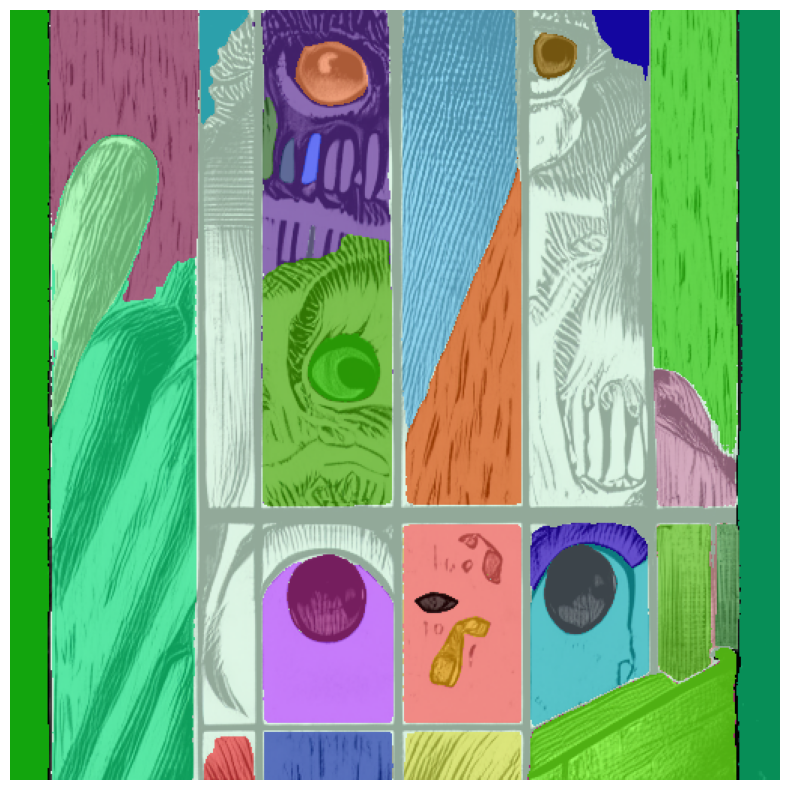

In [36]:
show_anns_on_image(image, masks)


In [37]:
def pad_to_square(image):
    h, w, c = image.shape
    size = max(h, w)
    padded_image = np.zeros((size, size, c), dtype=np.uint8)
    y_offset = (size - h) // 2
    x_offset = (size - w) // 2
    padded_image[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return padded_image

def resize_image(image, size=(224, 224)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return resized_image


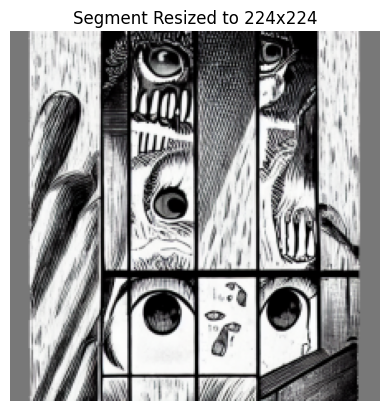

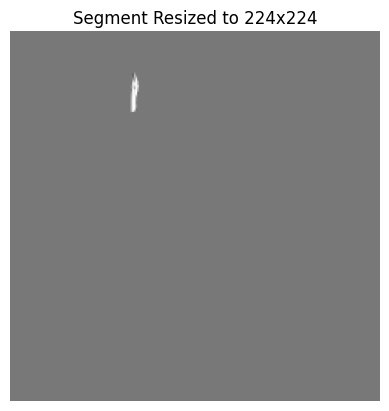

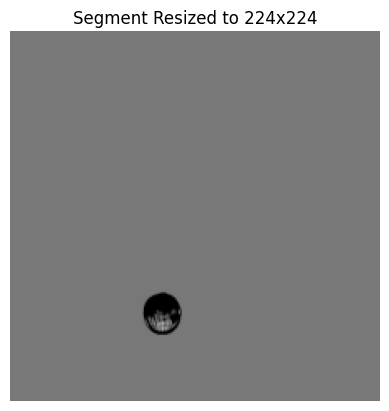

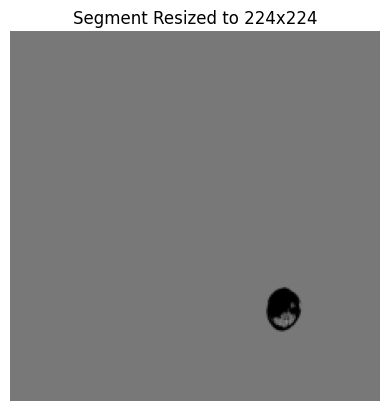

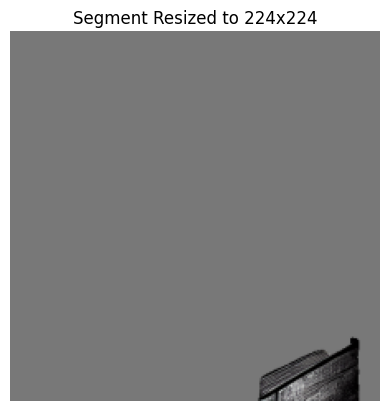

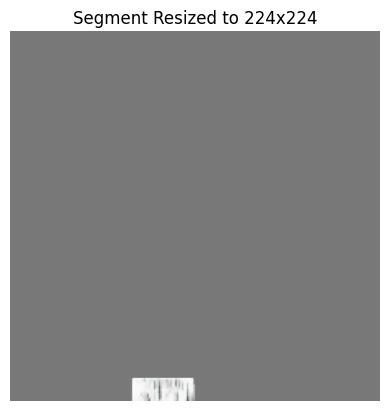

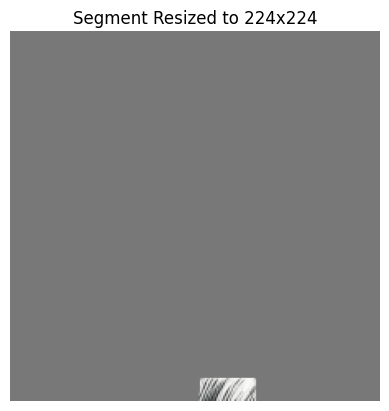

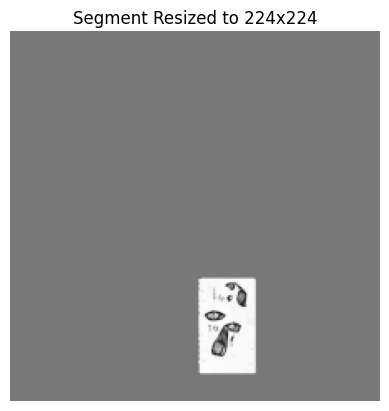

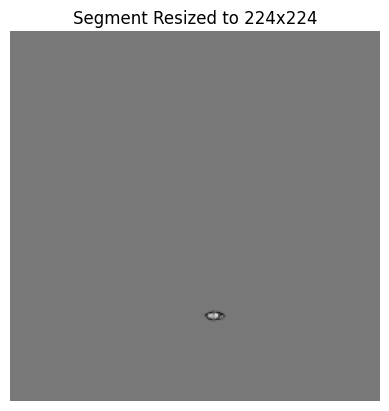

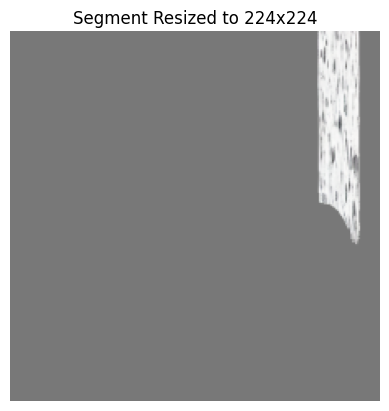

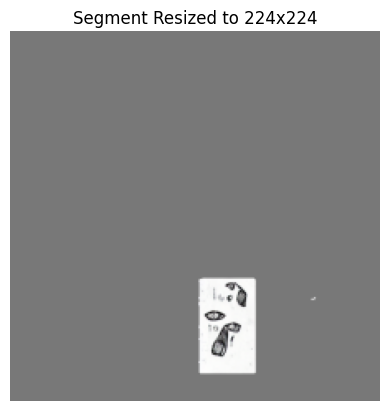

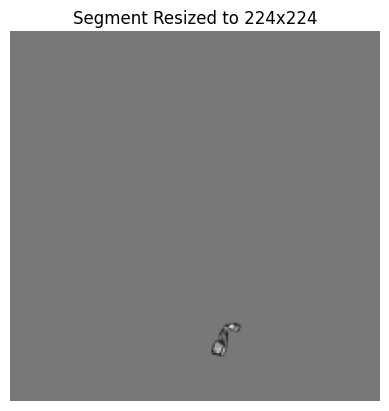

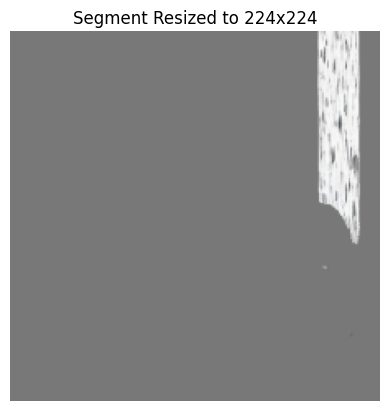

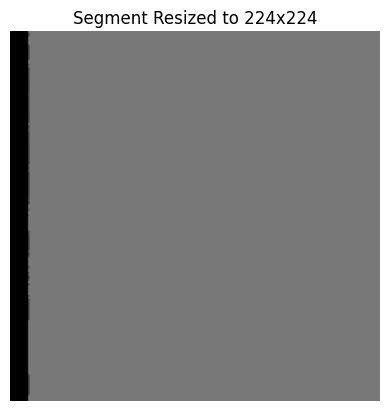

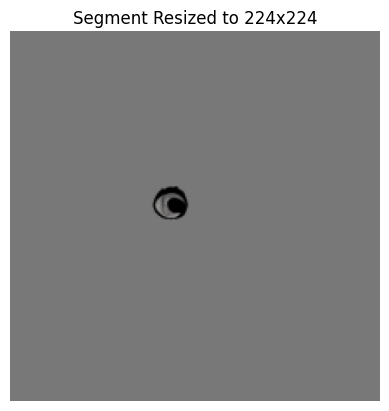

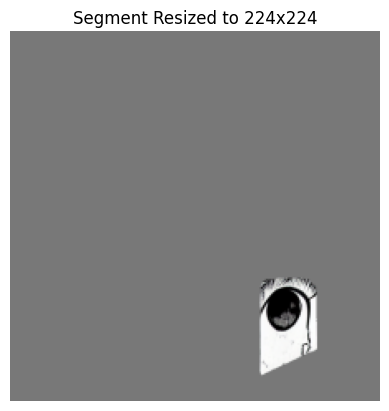

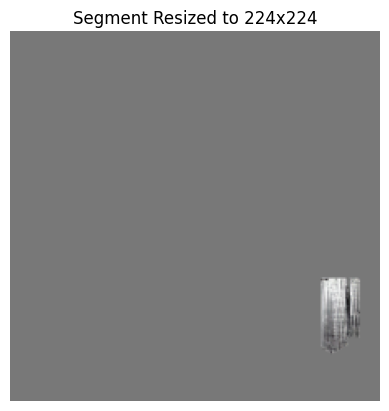

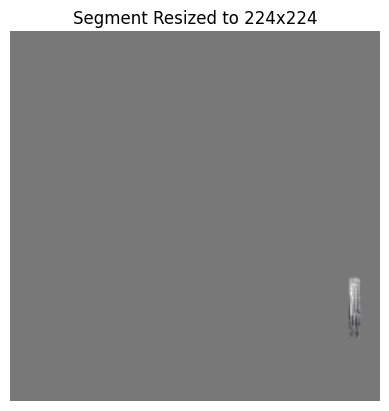

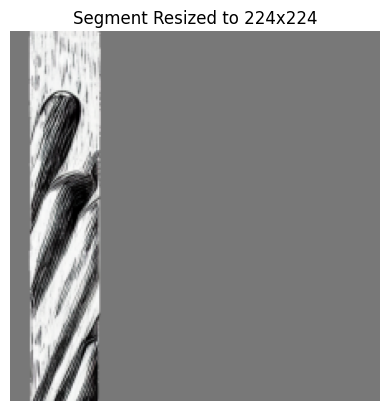

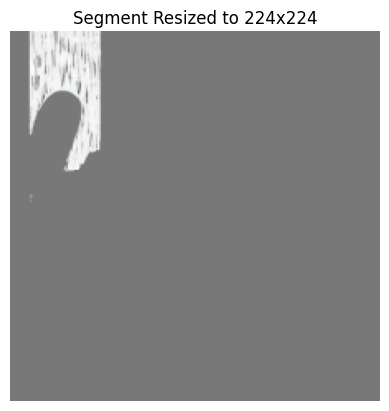

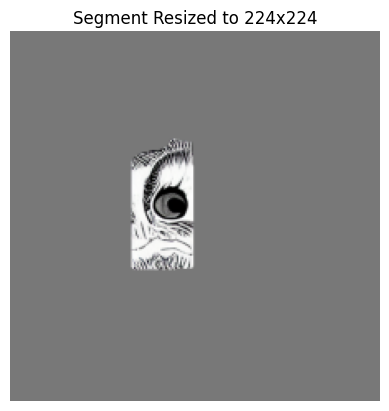

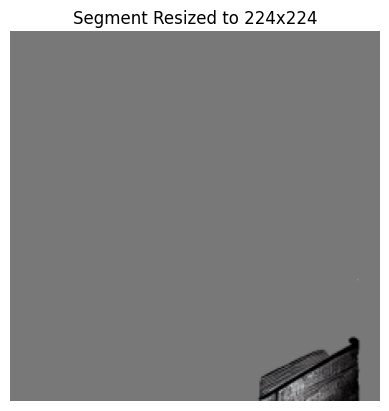

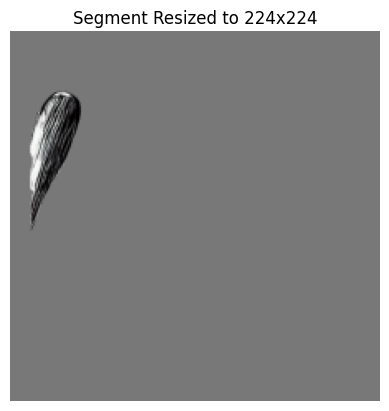

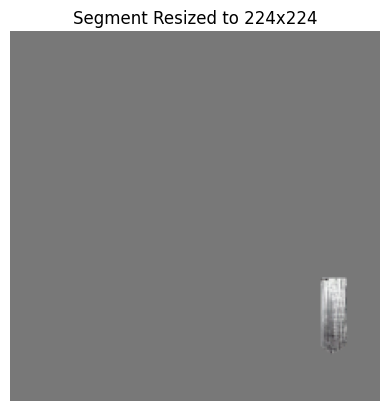

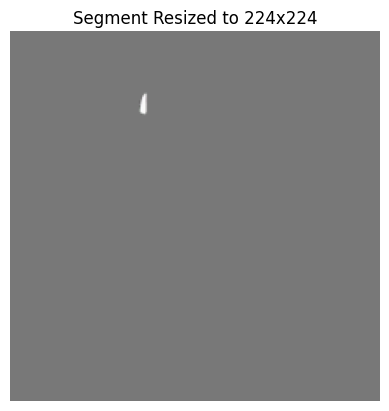

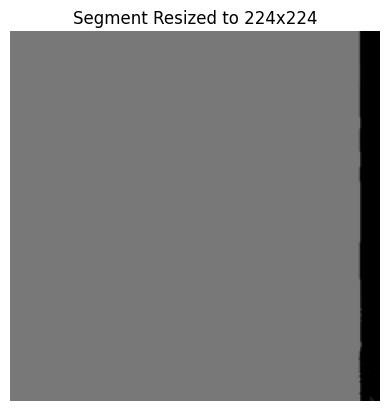

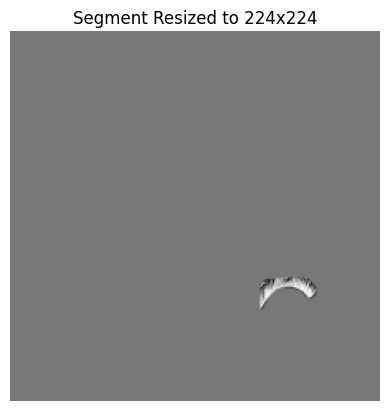

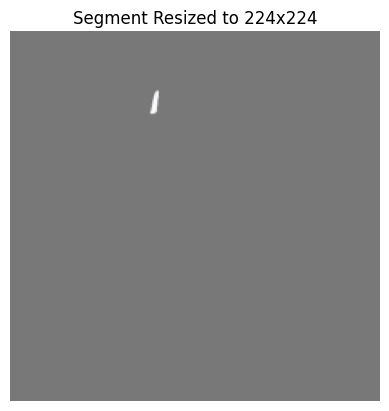

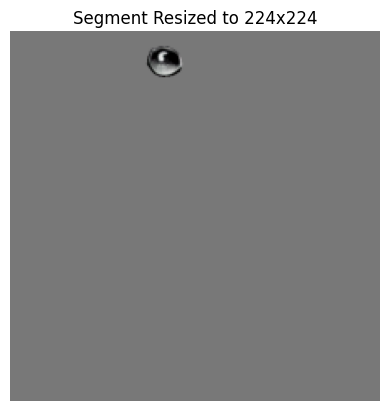

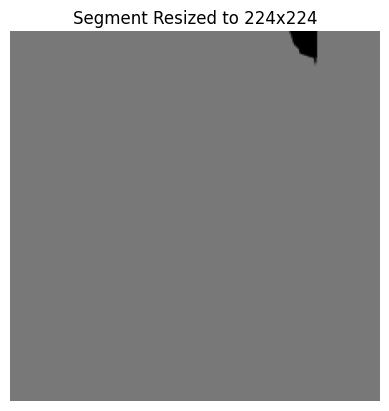

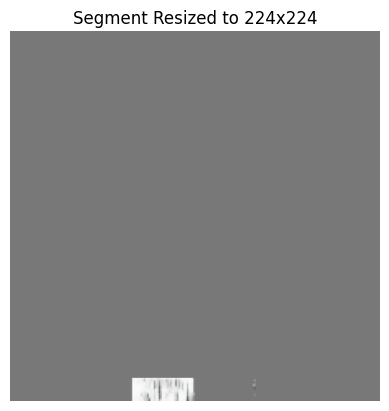

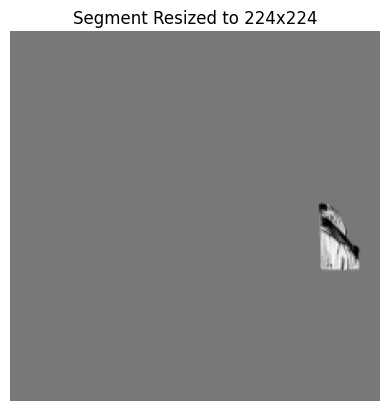

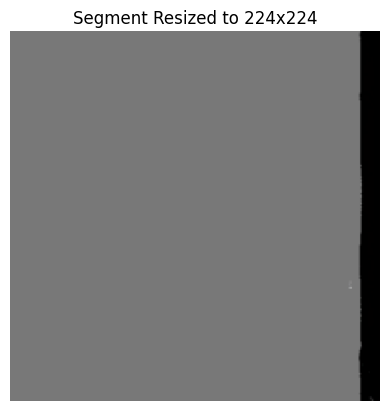

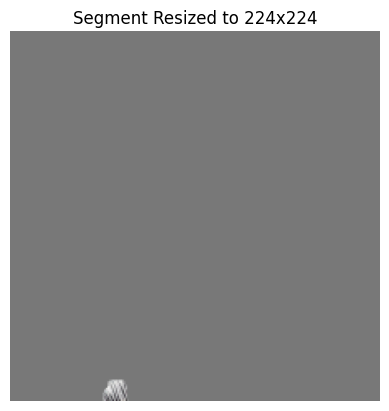

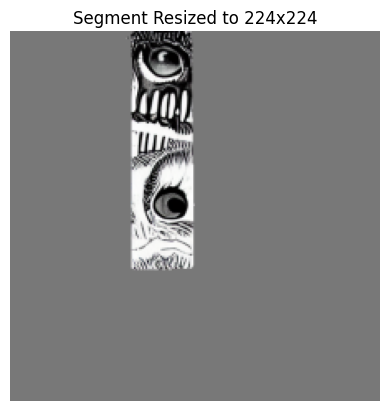

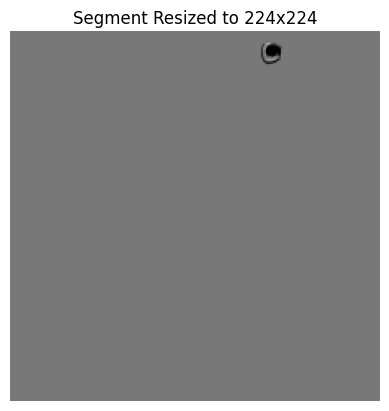

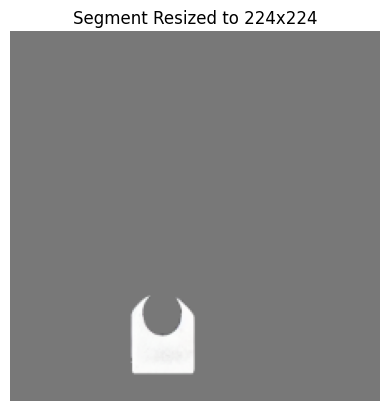

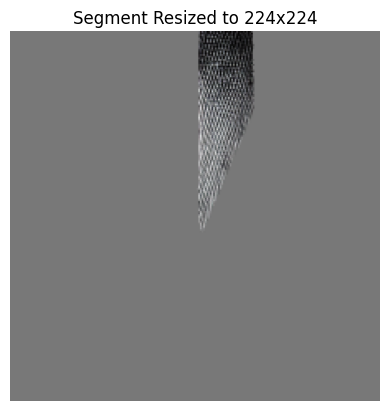

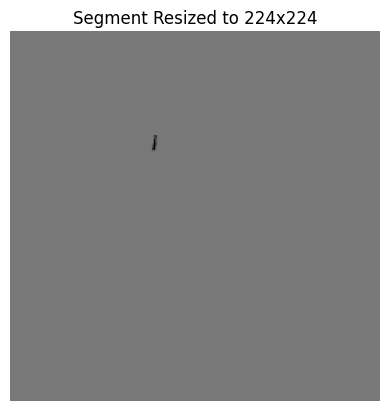

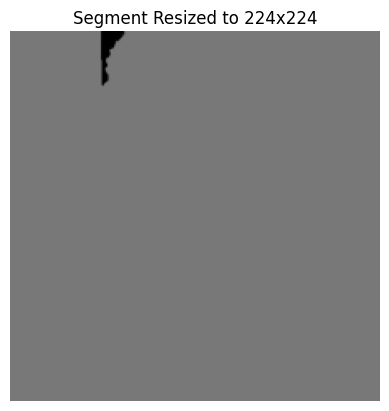

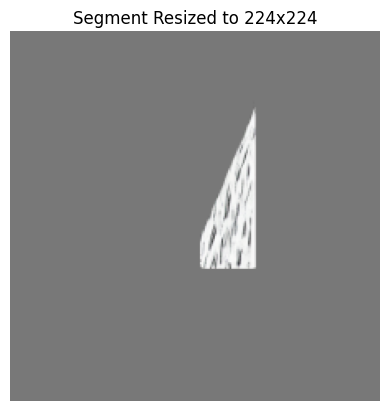

In [38]:
for mask in masks:
    segmentation = mask['segmentation']

    # Mask out all other parts
    segment_image = image.copy()
    mask_bool = segmentation.astype(bool)
    segment_image[~mask_bool] = 120  # Set background pixels to black

    segment_resized = cv2.resize(segment_image, (224, 224), interpolation=cv2.INTER_AREA)

    # Visualize the resized image
    plt.figure()
    plt.imshow(segment_resized)
    plt.axis('off')
    plt.title('Segment Resized to 224x224')
    plt.show()
